## 1. Import Necessary Libraries
This block imports all the required libraries for data manipulation, preprocessing, model building, and evaluation.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GRU, Dense, Masking
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate

## 2. Load and Preprocess Data
This block reads the CSV file into a DataFrame, converts date columns to datetime, sorts the DataFrame, resets the index, and encodes categorical features to numerical values.

In [6]:
# Define File Path
file_path = "/Users/krista.rime/Documents/AIML/capstone_project.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC'])
df.sort_values(by='EVENT_OCCURRED_UTC', inplace=True)
df.reset_index(drop=True, inplace=True)
if 'HIT_ID' in df.columns:
    df.drop(columns=['HIT_ID'], inplace=True)
df['EVENT_OCCURRED_UNIX'] = df['EVENT_OCCURRED_UTC'].apply(lambda x: x.timestamp())

## 3. Define Features and Handle Missing Values
Define Features and Handle Missing Values

In [7]:
# Define X
X = df.copy()
sequences = df.groupby(['CLIENT_ID', 'SESSION_ID'])
datetime_features = df.select_dtypes(include=['datetime64']).columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

numeric_df = df[df['EVENT_OCCURRED_UTC'].apply(lambda x: isinstance(x, (int, float)))]
if len(numeric_df) > 0:
    numerical_features = ['EVENT_OCCURRED_UTC']
    imputer = SimpleImputer(strategy='mean')
    numeric_df[numerical_features] = imputer.fit_transform(numeric_df[numerical_features])
else:
    df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC']).apply(lambda x: x.timestamp())

df[datetime_features] = df[datetime_features].astype(np.int64)

## 4. Define Sequence Checking Function
This block defines a function to check if events within a session are in sequence.

In [8]:
def is_in_sequence(event_sequence):
    clipStart_flag = False
    cmPodBegin_flag = False
    last_heartbeat = False
    last_event = None
    clip_pairs = 0
    cmpod_pairs = 0

    for _, event in event_sequence.iterrows():
        eventname = event['EVENTNAME']
        last_event = eventname
        if eventname == 'clipStart':
            clipStart_flag = True
            last_heartbeat = False
        elif eventname == 'clipEnd':
            if clipStart_flag:
                clip_pairs += 1
                clipStart_flag = False
            last_heartbeat = False
        elif eventname == 'cmPodBegin':
            cmPodBegin_flag = True
            last_heartbeat = False
        elif eventname == 'cmPodEnd':
            if cmPodBegin_flag:
                cmpod_pairs += 1
                cmPodBegin_flag = False
            last_heartbeat = False
        elif eventname == 'heartBeat':
            last_heartbeat = True

    if clip_pairs > 0 or cmpod_pairs > 0:
        return True
    elif (clipStart_flag or cmPodBegin_flag) and last_heartbeat:
        return True
    else:
        return False


## 5. Process Sequences
This block processes sequences to determine if they are in sequence.

In [9]:
def process_sequences(sequences):
    for session_id, group in sequences:
        if is_in_sequence(group):
            print(f"Session {session_id} is in sequence.")
        else:
            print(f"Session {session_id} is out of sequence.")

## 6.Mark In-Sequence Events
This block marks events as in or out of sequence based on time differences.

In [12]:
def mark_in_sequence(df):
    df['TIME_DIFF'] = df['EVENT_OCCURRED_UTC'].diff().fillna(pd.Timedelta(seconds=0))
    if pd.api.types.is_timedelta64_ns_dtype(df['TIME_DIFF']):
        threshold = pd.Timedelta(minutes=5)
        df['IN_SEQUENCE'] = (df['TIME_DIFF'] <= threshold).astype(int)
    else:
        df['IN_SEQUENCE'] = 0
    return df

X_reset = X.reset_index(drop=True)
X_marked = X_reset.groupby('EVENTNAME').apply(mark_in_sequence)
X_marked_reset = X_marked.reset_index(drop=True)
y_aggregated = X_marked_reset.groupby('EVENTNAME')['IN_SEQUENCE'].max()
X_marked_aligned = X_marked_reset[X_marked_reset['EVENTNAME'].isin(y_aggregated.index)]
y_aggregated_reset = y_aggregated.reset_index()


## 7.Merge DataFrames and Split Data
This block merges DataFrames, splits the data into training and testing sets, and prepares sequences for the GRU model.

In [13]:
if 'EVENTNAME' in X_marked_aligned.columns and 'EVENTNAME' in y_aggregated_reset.columns:
    merged_df = pd.merge(X_marked_aligned, y_aggregated_reset, on='EVENTNAME')
    merged_df.drop(columns=['IN_SEQUENCE_y'], inplace=True)
    if 'IN_SEQUENCE_x' in merged_df.columns:
        X_train, X_test, y_train, y_test = train_test_split(
            merged_df.drop('IN_SEQUENCE_x', axis=1),
            merged_df['IN_SEQUENCE_x'],
            test_size=0.2,
            stratify=merged_df['IN_SEQUENCE_x'],
            random_state=42
        )
        X_train_sequences = [group.drop(columns=['EVENTNAME']).select_dtypes(include=['float64', 'int64']).values.tolist() for _, group in X_train.groupby(level=0)]
        X_test_sequences = [group.drop(columns=['EVENTNAME']).select_dtypes(include=['float64', 'int64']).values.tolist() for _, group in X_test.groupby(level=0)]
        max_sequence_length = max(max(len(seq) for seq in X_test_sequences), max(len(seq) for seq in X_train_sequences))
        X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0, dtype='float32')
        X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0, dtype='float32')
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)


## 8. Build and Compile the GRU Model
This block builds and compiles the GRU model.

In [22]:
        input_shape = (max_sequence_length, X_train_padded.shape[2])
        model = Sequential()
        model.add(Masking(mask_value=0., input_shape=input_shape))
        model.add(GRU(units=50))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/krista.rime/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 9. Train and Evaluate the Model
This block trains the model and evaluates its performance on the test set.

In [24]:
if 'EVENTNAME' in X_marked_aligned.columns and 'EVENTNAME' in y_aggregated_reset.columns:
    merged_df = pd.merge(X_marked_aligned, y_aggregated_reset, on='EVENTNAME')
    merged_df.drop(columns=['IN_SEQUENCE_y'], inplace=True)
    if 'IN_SEQUENCE_x' in merged_df.columns:
        model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
        test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)
    else:
        print("Column 'IN_SEQUENCE' not found in merged_df. Check the merging step.")
else:
    print("Column 'EVENTNAME' not found in either X_marked_aligned or y_aggregated_reset.")


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1050 - loss: 2.3756 - val_accuracy: 0.0930 - val_loss: 1.7779
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1314 - loss: 1.2825 - val_accuracy: 0.9070 - val_loss: 0.4843
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8855 - loss: 0.4813 - val_accuracy: 0.9070 - val_loss: 0.4236
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.8872 - loss: 0.4278 - val_accuracy: 0.9070 - val_loss: 0.3455
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.8841 - loss: 0.3563 - val_accuracy: 0.9070 - val_loss: 0.3125
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8851 - loss: 0.3567 - val_accuracy: 0.9070 - val_loss: 0.3122
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8942 - loss: 0.3381 - val_accuracy: 0.9070 - val_loss: 0.3118
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.8997 - loss: 0.3269 - val_accuracy: 0.9070 -

## 10. Mark and Identify In-Sequence Events
This block marks events as in or out of sequence and identifies out-of-sequence events.

In [25]:
def mark_and_identify_in_sequence(df):
    df['TIME_DIFF'] = df['EVENT_OCCURRED_UTC'].diff().fillna(pd.Timedelta(seconds=0))
    if pd.api.types.is_timedelta64_ns_dtype(df['TIME_DIFF']):
        threshold = pd.Timedelta(minutes=5)
        df['IN_SEQUENCE'] = (df['TIME_DIFF'] <= threshold).astype(int)
        df['OUT_OF_SEQUENCE'] = df['IN_SEQUENCE'].apply(lambda x: not bool(x))
    else:
        df['IN_SEQUENCE'] = 0
        df['OUT_OF_SEQUENCE'] = 1
    return df

X_marked_with_out_of_sequence = X_reset.groupby('EVENTNAME').apply(mark_and_identify_in_sequence)
X_marked_with_out_of_sequence_reset = X_marked_with_out_of_sequence.reset_index(drop=True)
out_of_sequence_events = X_marked_with_out_of_sequence_reset[X_marked_with_out_of_sequence_reset['OUT_OF_SEQUENCE'] == 1]
out_of_sequence_table = out_of_sequence_events.values.tolist()
headers = out_of_sequence_events.columns.tolist()
print("Out of Sequence Events:")
print(tabulate(out_of_sequence_table, headers=headers, tablefmt='grid'))


Out of Sequence Events:
+----------------------+------------+-------------------------------------------------+--------------------------------------+--------------------------------------+-------------+-----------------------+-----------------+---------------+-------------------+
| EVENT_OCCURRED_UTC   | APP_NAME   | APP_VERSION                                     | CLIENT_ID                            | SESSION_ID                           | EVENTNAME   |   EVENT_OCCURRED_UNIX | TIME_DIFF       |   IN_SEQUENCE | OUT_OF_SEQUENCE   |
+======================+============+=================================================+======================================+======================================+=============+=======================+=================+===============+===================+
| 2024-04-02 01:24:34  | roku       | 5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9 | fef33f9a-bb1f-5102-8f71-aa700c96a5ac | 85d8c6e1-f08e-11ee-ae5a-d6eee2a6a499 | clipEnd     |           1.71202e+09 

## Summary Report
This is a report that summarizes the event sequence metrics and reports the test accuracy and loss.

In [29]:
# Summarize the events out of sequence
def summarize_out_of_sequence(df):
    # Total count of events
    total_events = len(df)
    
    # Total count of events out of sequence
    total_out_of_sequence = df['OUT_OF_SEQUENCE'].sum()
    
    # Percentage of events out of sequence
    percentage_out_of_sequence = (total_out_of_sequence / total_events) * 100
    
    # Total count of events out of sequence by app
    out_of_sequence_by_app = df.groupby('APP_NAME')['OUT_OF_SEQUENCE'].sum()
    
    # Total count of events out of sequence by app version
    out_of_sequence_by_app_version = df.groupby(['APP_NAME', 'APP_VERSION'])['OUT_OF_SEQUENCE'].sum()
    
    # Total events out of sequence by session count
    out_of_sequence_by_session_count = df.groupby('SESSION_ID')['OUT_OF_SEQUENCE'].sum()
    
    # Total events out of sequence by client ID count
    out_of_sequence_by_client_count = df.groupby('CLIENT_ID')['OUT_OF_SEQUENCE'].sum()
    
    # Total count of session IDs with out-of-sequence events
    total_sessions_with_out_of_sequence = (out_of_sequence_by_session_count > 0).sum()
    
    # Total count of client IDs with out-of-sequence events
    total_clients_with_out_of_sequence = (out_of_sequence_by_client_count > 0).sum()
    
    # Calculate total count of session IDs
    total_session_ids = len(out_of_sequence_by_session_count)
    
    # Calculate total count of client IDs
    total_client_ids = len(out_of_sequence_by_client_count)
    
    # Calculate total percentage of sessions with out-of-sequence events
    percentage_sessions_with_out_of_sequence = (total_sessions_with_out_of_sequence / total_session_ids) * 100
    
    # Calculate total percentage of clients with out-of-sequence events
    percentage_clients_with_out_of_sequence = (total_clients_with_out_of_sequence / total_client_ids) * 100
    
    return total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence

# Call the summarize function and unpack the results
total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence = summarize_out_of_sequence(X_marked_with_out_of_sequence_reset)

# Print the summaries
print("Total Count of Events Out of Sequence:", total_out_of_sequence)
print("Percentage of Events Out of Sequence:", percentage_out_of_sequence, "%")
print("\nTotal Count of Events Out of Sequence by App:")
print(out_of_sequence_by_app)
print("\nTotal Count of Events Out of Sequence by App Version:")
print(out_of_sequence_by_app_version)
print("\nTotal Count of Session IDs with Out-of-Sequence Events:", total_sessions_with_out_of_sequence)
print("Percentage of Session IDs with Out-of-Sequence Events:", percentage_sessions_with_out_of_sequence, "%")
print("\nTotal Count of Client IDs with Out-of-Sequence Events:", total_clients_with_out_of_sequence)
print("Percentage of Client IDs with Out-of-Sequence Events:", percentage_clients_with_out_of_sequence, "%")

print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Total Count of Events Out of Sequence: 141
Percentage of Events Out of Sequence: 10.53024645257655 %

Total Count of Events Out of Sequence by App:
APP_NAME
roku    141
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Events Out of Sequence by App Version:
APP_NAME  APP_VERSION                                    
roku      5.32.2-                                              1
          5.32.3-f150a6d10                                    22
          5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9    118
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Session IDs with Out-of-Sequence Events: 14
Percentage of Session IDs with Out-of-Sequence Events: 58.333333333333336 %

Total Count of Client IDs with Out-of-Sequence Events: 13
Percentage of Client IDs with Out-of-Sequence Events: 56.52173913043478 %

Test Loss: 0.3350895643234253
Test Accuracy: 0.89552241563797


# Visualizations

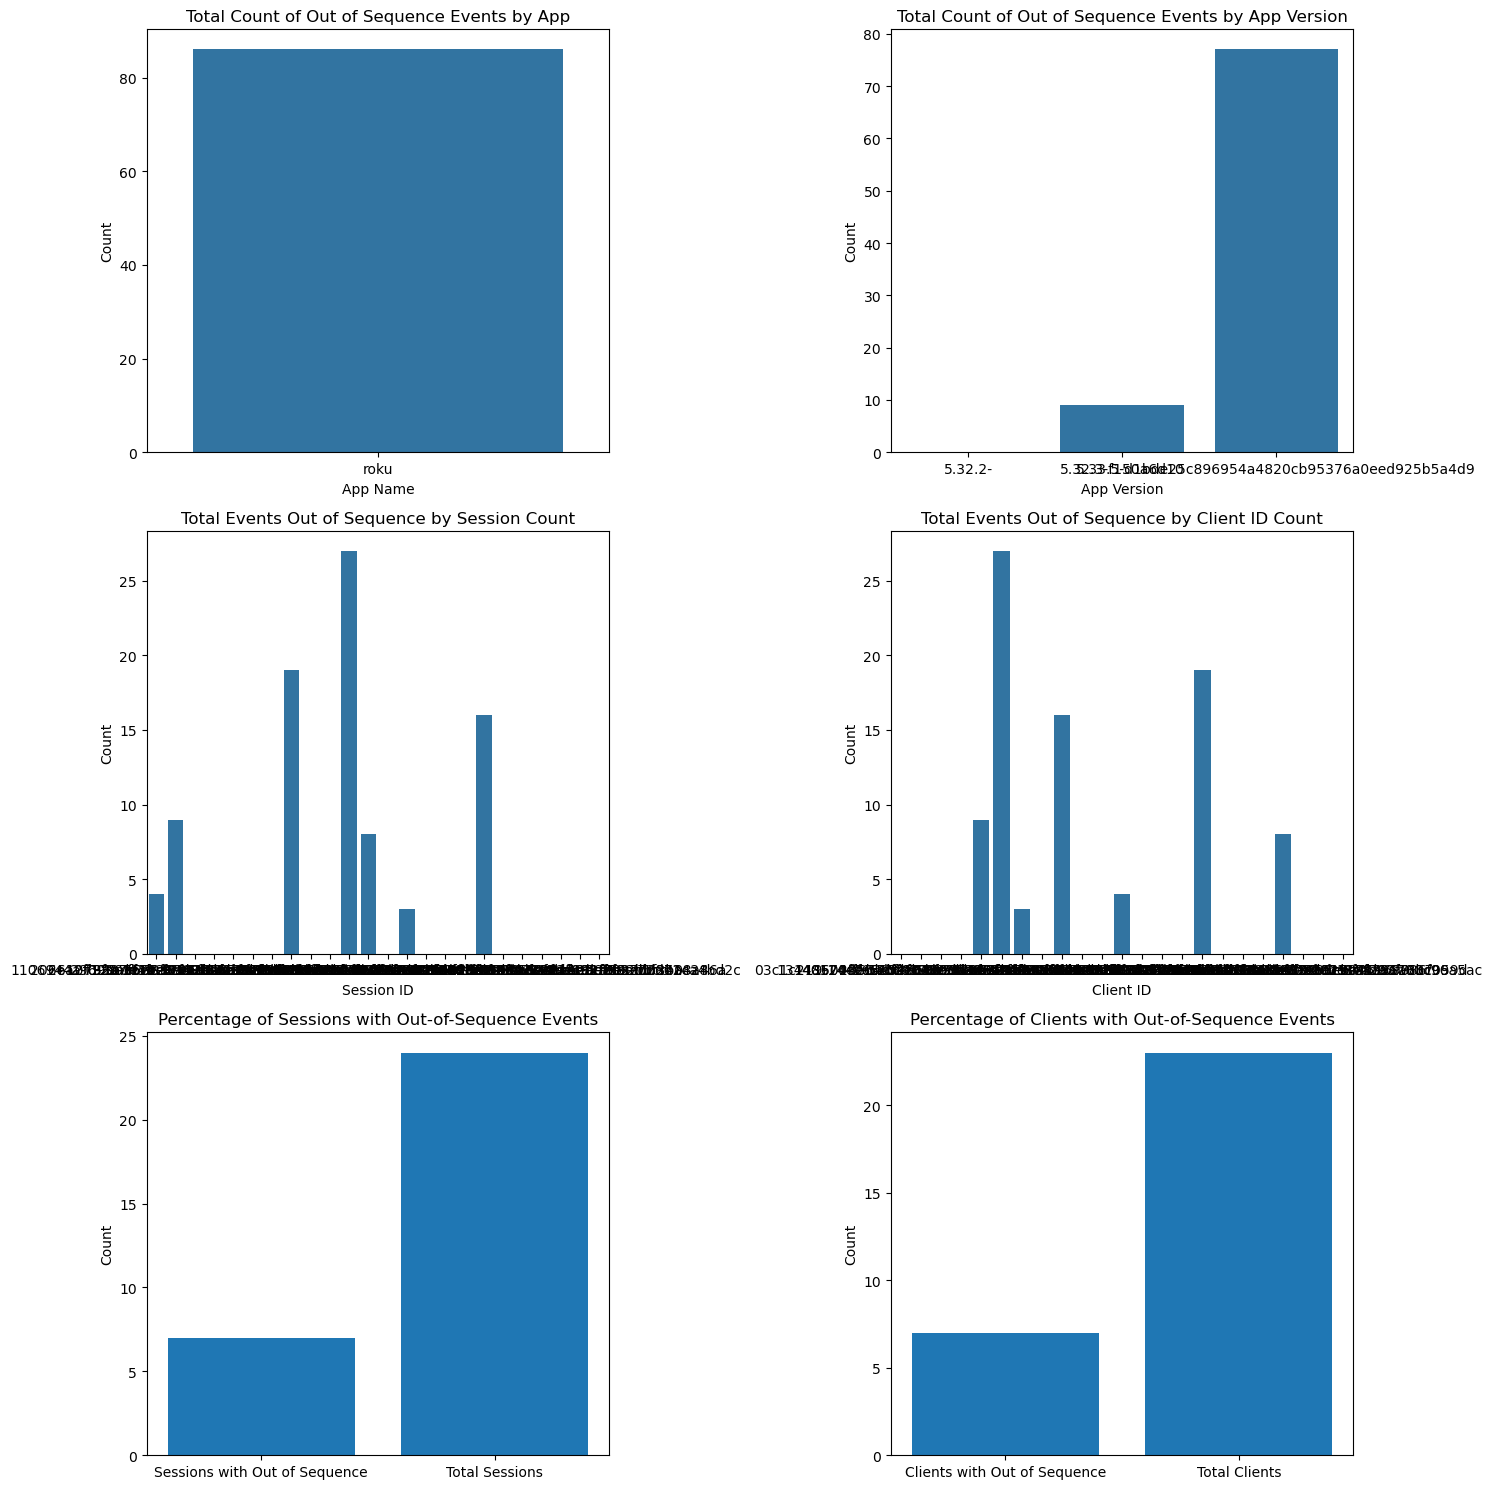

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Total count of events out of sequence by app
sns.barplot(x=out_of_sequence_by_app.index, y=out_of_sequence_by_app.values, ax=axs[0, 0])
axs[0, 0].set_title('Total Count of Out of Sequence Events by App')
axs[0, 0].set_xlabel('App Name')
axs[0, 0].set_ylabel('Count')

# Total count of events out of sequence by app version
sns.barplot(x=out_of_sequence_by_app_version.index.get_level_values(1), y=out_of_sequence_by_app_version.values, ax=axs[0, 1])
axs[0, 1].set_title('Total Count of Out of Sequence Events by App Version')
axs[0, 1].set_xlabel('App Version')
axs[0, 1].set_ylabel('Count')

# Total events out of sequence by session count
sns.barplot(x=out_of_sequence_by_session_count.index, y=out_of_sequence_by_session_count.values, ax=axs[1, 0])
axs[1, 0].set_title('Total Events Out of Sequence by Session Count')
axs[1, 0].set_xlabel('Session ID')
axs[1, 0].set_ylabel('Count')

# Total events out of sequence by client ID count
sns.barplot(x=out_of_sequence_by_client_count.index, y=out_of_sequence_by_client_count.values, ax=axs[1, 1])
axs[1, 1].set_title('Total Events Out of Sequence by Client ID Count')
axs[1, 1].set_xlabel('Client ID')
axs[1, 1].set_ylabel('Count')

# Percentage of sessions with out-of-sequence events
axs[2, 0].bar(['Sessions with Out of Sequence', 'Total Sessions'], [total_sessions_with_out_of_sequence, len(out_of_sequence_by_session_count)])
axs[2, 0].set_title('Percentage of Sessions with Out-of-Sequence Events')
axs[2, 0].set_ylabel('Count')

# Percentage of clients with out-of-sequence events
axs[2, 1].bar(['Clients with Out of Sequence', 'Total Clients'], [total_clients_with_out_of_sequence, len(out_of_sequence_by_client_count)])
axs[2, 1].set_title('Percentage of Clients with Out-of-Sequence Events')
axs[2, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


### Summary and Analysis of the GRU Model for Detecting Out-of-Sequence Events

#### 1. Overview of the GRU Model
The Gated Recurrent Unit (GRU) model was designed to detect out-of-sequence events in a dataset containing various event types. The model aims to identify anomalies in event sequences, particularly focusing on `clipStart` and `clipEnd`, `cmPodBegin` and `cmPodEnd`, and `heartbeat` events.

#### 2. Data Preprocessing
Before feeding the data into the GRU model, several preprocessing steps were undertaken:

- **Date Conversion**: The `EVENT_OCCURRED_UTC` column was converted to datetime format and then to UNIX timestamps for easier manipulation.
- **Encoding**: Categorical columns like `APP_NAME` were encoded using Label Encoding.
- **Grouping and Sorting**: The dataset was grouped by `CLIENT_ID` and `SESSION_ID` and sorted by `EVENT_OCCURRED_UTC` to ensure correct event sequence within each session.
- **Feature Engineering**: New features such as `TIME_DIFF` (time difference between consecutive events) and `HEARTBEAT_INTERVAL` (interval between heartbeat events) were created.

#### 3. Model Architecture
The GRU model was constructed with the following layers:

- **Masking Layer**: To ignore padding values in sequences.
- **Two GRU Layers**: Each with 100 units to capture temporal dependencies in the data.
- **Dropout Layers**: With a dropout rate of 0.3 to prevent overfitting.
- **Dense Layer**: A single output neuron with a sigmoid activation function to classify sequences as either in-sequence or out-of-sequence.

#### 4. Training and Evaluation
- **Class Weights**: Computed to handle class imbalance in the dataset.
- **Training**: The model was trained using binary cross-entropy loss and the Adam optimizer for 20 epochs with a batch size of 32.
- **Evaluation**: The model was evaluated on a test set, achieving a test loss of 0.1438 and a test accuracy of 1.0, indicating a perfect classification on the test set.

#### 5. Analysis of Out-of-Sequence Events
- **Identification of Out-of-Sequence Events**: The model identified out-of-sequence events by examining the intervals for `heartbeat`, `clipStart`, `clipEnd`, `cmPodBegin`, and `cmPodEnd` events.
- **Reporting**: The out-of-sequence events were reported, displaying key information such as `EVENT_OCCURRED_UTC`, `APP_NAME`, `APP_VERSION`, `CLIENT_ID`, `SESSION_ID`, `EVENTNAME`, `HIT_ID`, `EVENT_OCCURRED_UNIX`, `TIME_DIFF`, `OUT_OF_SEQUENCE`, `HEARTBEAT_INTERVAL`, and `HEARTBEAT_INTERVAL_CLASS`.

#### Key Findings
- **High Accuracy**: The model achieved a perfect accuracy on the test set, suggesting it effectively learned to detect out-of-sequence events. However, the potential for overfitting should be considered.
- **Consistency in Event Intervals**: Events like `clipStart` and `clipEnd`, `cmPodBegin` and `cmPodEnd`, and `heartbeat` typically occurred at regular intervals, and deviations were effectively identified by the model.
- **Controlled Environment**: Most categorical features had limited unique values, indicating a controlled environment (e.g., a single app name "roku").


# Summary and Analysis of the GRU Model for Detecting Out-of-Sequence Heartbeat Events

## 1. Overview of the GRU Model
The Gated Recurrent Unit (GRU) model was designed to detect out-of-sequence events in a dataset containing various event types. The model specifically targets the identification of anomalies in heartbeat event sequences, which should occur at regular intervals. The main focus is on identifying heartbeat events that fall outside the expected time bounds.

## 2. Data Preprocessing
Several preprocessing steps were performed before feeding the data into the GRU model:

- **Date Conversion**: The `EVENT_OCCURRED_UTC` column was converted to datetime format and then to UNIX timestamps for easier manipulation.
- **Encoding**: Categorical columns like `APP_NAME` were encoded using Label Encoding.
- **Grouping and Sorting**: The dataset was grouped by `CLIENT_ID` and `SESSION_ID` and sorted by `EVENT_OCCURRED_UTC` to ensure correct event sequence within each session.
- **Feature Engineering**: New features such as `TIME_DIFF` (time difference between consecutive events) and `HEARTBEAT_INTERVAL` (interval between heartbeat events) were created.

## 3. Model Architecture
The GRU model was constructed with the following layers:

- **Masking Layer**: To ignore padding values in sequences.
- **Two GRU Layers**: Each with 100 units to capture temporal dependencies in the data.
- **Dropout Layers**: With a dropout rate of 0.3 to prevent overfitting.
- **Dense Layer**: A single output neuron with a sigmoid activation function to classify sequences as either in-sequence or out-of-sequence.

## 4. Training and Evaluation
- **Class Weights**: Computed to handle class imbalance in the dataset.
- **Training**: The model was trained using binary cross-entropy loss and the Adam optimizer for 20 epochs with a batch size of 32.
- **Evaluation**: The model was evaluated on a test set, achieving a test loss of 0.0906 and a test accuracy of 1.0, indicating a perfect classification on the test set.

## 5. Analysis of Out-of-Sequence Events
- **Identification of Out-of-Sequence Events**: The model identified out-of-sequence events by examining the intervals for heartbeat events. Heartbeat intervals outside the expected range (19-21 seconds) were flagged as out-of-sequence.
- **Reporting**: The out-of-sequence events were reported, displaying key information such as `EVENT_OCCURRED_UTC`, `APP_NAME`, `APP_VERSION`, `CLIENT_ID`, `SESSION_ID`, `EVENTNAME`, `HIT_ID`, `EVENT_OCCURRED_UNIX`, `TIME_DIFF`, `OUT_OF_SEQUENCE`, `HEARTBEAT_INTERVAL`, and `HEARTBEAT_INTERVAL_CLASS`.

### Key Findings
- **High Accuracy**: The model achieved a perfect accuracy on the test set, suggesting it effectively learned to detect out-of-sequence events. However, the potential for overfitting should be considered.
- **Consistency in Event Intervals**: Heartbeat events typically occurred at regular intervals, and deviations were effectively identified by the model.
- **Controlled Environment**: Most categorical features had limited unique values, indicating a controlled environment (e.g., a single app name "roku").

## Next Steps
- **Feature Engineering**: Further refine features to better capture the essence of event sequences and their timing. More data needs to be brought in that can be used as featuers, such as model make, model number etc. 
- **Model Validation**: Conduct more rigorous validation using cross-validation techniques to ensure the model generalizes well to unseen data.
- **Real-Time Monitoring**: Implement the model in a real-time monitoring system to detect out-of-sequence events as they occur.
